# Cell Vision
## Getting started
For the initial demonstration of developing a CNN for mask generation, I will 
be using a curated dataset comprised of images of pedestrians in the street 
with accompanying masks known as the Penn-Fundan dataset. This data can be 
retrieved using the `getTestData.sh` file found in the `scripts/` directory. 
I would recommend running this from the parent directory of the project. 

The following libraries are required to run the analysis:
- torch -> the backbone of machine learning that we will be using
- torchvision
- matplotlib -> for showing images and graphs
- cv2 -> I was having issues using the `torchvision.io.read_image` function on 
a majority of images from the dataset but using opencv seems to work

These libraries can be installed using pip3. 

## Process schematic
In order to actually run this, we have to have a blueprint and understand the components. 

In [1]:
# Library imports required for analysis
import os

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

import cv2 
import matplotlib.pyplot as plt 

In [2]:
class FlouCellsDataset(torch.utils.data.Dataset):
    def __init__(self, root: str, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "images"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "masks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        mask_path = os.path.join(self.root, "masks", self.masks[idx])
        
        img = cv2.imread(img_path)
        mask = cv2.cvtColor(cv2.imread(mask_path), cv2.COLOR_BGR2GRAY)
        sample = {"image": img, "mask": mask}
        
        if self.transforms:
            sample = self.transforms(sample)
        
        return sample
    
    def __len__(self):
        return len(self.imgs)
    

class resize:
    def __init__(self, out_size: int):
        self.out_size = out_size

    def __call__(self, sample):
        img, msk = sample["image"], sample["mask"]
        img_resized = cv2.resize(img, (self.out_size, self.out_size))
        msk_resized = cv2.resize(msk, (self.out_size, self.out_size))
        return {"image" : img_resized, "mask" : msk_resized}
    

class toTensor:
    def __call__(self, sample):
        img, msk = sample["image"], sample["mask"]
        img_tensor = torch.from_numpy(img).float().transpose(0, 2) / 255
        msk_tensor = torch.from_numpy(np.expand_dims(msk, axis=0)).float().transpose(1, 2) / 255
        return {"image" : img_tensor, "mask" : msk_tensor}

In [3]:
fc_dataset = FlouCellsDataset("data/", transforms.Compose(transforms=[resize(512), toTensor()]))

torch.float32


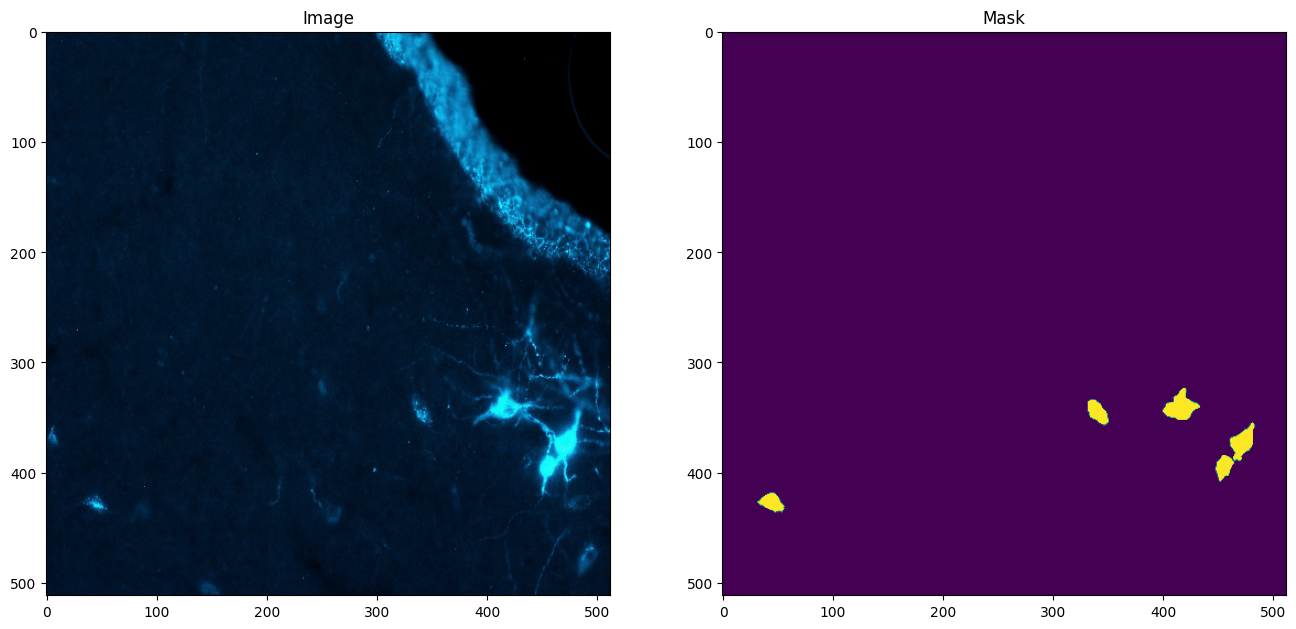

In [4]:
smpl = fc_dataset.__getitem__(0)
plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.title("Image")
plt.imshow(smpl["image"].transpose(0, 2))
plt.subplot(122)
plt.title("Mask")
plt.imshow(smpl["mask"].transpose(0, 2))
print(smpl["mask"].dtype)

In [5]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Encoder
        # input: [3, 512, 512]
        self.e11 = nn.Conv2d(3, 64, kernel_size=3, padding=1) 
        self.e12 = nn.Conv2d(64, 64, kernel_size=3, padding=1) 
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # output: [64, 256, 256]

        
        self.e21 = nn.Conv2d(64, 128, kernel_size=3, padding=1) 
        self.e22 = nn.Conv2d(128, 128, kernel_size=3, padding=1) 
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # output: [128, 128, 128]

        
        self.e31 = nn.Conv2d(128, 256, kernel_size=3, padding=1) 
        self.e32 = nn.Conv2d(256, 256, kernel_size=3, padding=1) 
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # output: [256, 64, 64]

        
        self.e41 = nn.Conv2d(256, 512, kernel_size=3, padding=1) 
        self.e42 = nn.Conv2d(512, 512, kernel_size=3, padding=1) 
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 32x32x512

        
        self.e51 = nn.Conv2d(512, 1024, kernel_size=3, padding=1) # output: 30x30x1024
        self.e52 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1) # output: 28x28x1024


        # Decoder
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.d11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.d12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.d21 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.d22 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.d32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.d42 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        # Output layer
        self.outconv = nn.Conv2d(64, 1, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Encoder
        xe11 = F.relu(self.e11(x))
        xe12 = F.relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = F.relu(self.e21(xp1))
        xe22 = F.relu(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = F.relu(self.e31(xp2))
        xe32 = F.relu(self.e32(xe31))
        xp3 = self.pool3(xe32)

        xe41 = F.relu(self.e41(xp3))
        xe42 = F.relu(self.e42(xe41))
        xp4 = self.pool4(xe42)

        xe51 = F.relu(self.e51(xp4))
        xe52 = F.relu(self.e52(xe51))

        # Decoder
        xu1 = self.upconv1(xe52)
        xu11 = torch.cat([xu1, xe42], dim=0)
        xd11 = F.relu(self.d11(xu11))
        xd12 = F.relu(self.d12(xd11))

        xu2 = self.upconv2(xd12)
        xu22 = torch.cat([xu2, xe32], dim=0)
        xd21 = F.relu(self.d21(xu22))
        xd22 = F.relu(self.d22(xd21))

        xu3 = self.upconv3(xd22)
        xu33 = torch.cat([xu3, xe22], dim=0)
        xd31 = F.relu(self.d31(xu33))
        xd32 = F.relu(self.d32(xd31))

        xu4 = self.upconv4(xd32)
        xu44 = torch.cat([xu4, xe12], dim=0)
        xd41 = F.relu(self.d41(xu44))
        xd42 = F.relu(self.d42(xd41))

        # Output layer
        xd5 = self.outconv(xd42)
        out = self.sigmoid(xd5)
        return out
     

def dice_loss(pred: torch.Tensor, target: torch.Tensor, epsilon: float=1e-6):
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    dice = (2. * intersection + epsilon) / (union + epsilon)
    return 1 - dice.mean()

In [6]:
model = UNet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = dice_loss

In [7]:
# attempt to overfit to image
sample = fc_dataset.__getitem__(3)
image = sample['image']
mask = sample['mask']

for i in range(30):
    optimizer.zero_grad()
    output = model(image)
    loss = criterion(output, mask)
    loss.backward()
    optimizer.step()
    if i%5==0:
        print(f"{i} loss = {loss}")

0 loss = 0.9606831073760986
5 loss = 0.9600843787193298
10 loss = 0.9594278335571289
15 loss = 0.9583801031112671
20 loss = 0.9566535949707031
25 loss = 0.9532952308654785


In [ ]:
# actual training procedure
for epoch in range(1):
    epoch_loss = 0.0
    for i, sample in enumerate(fc_dataset):
        image = sample["image"]
        mask = sample["mask"]
        optimizer.zero_grad()

        output = model(image)
        loss = criterion(output, mask)
        loss.backward()
        optimizer.step()

        epoch_loss += loss
        if i%25==0:
            print(f"{i} loss = {loss}")

tensor(0.7907, grad_fn=<MaxBackward1>)


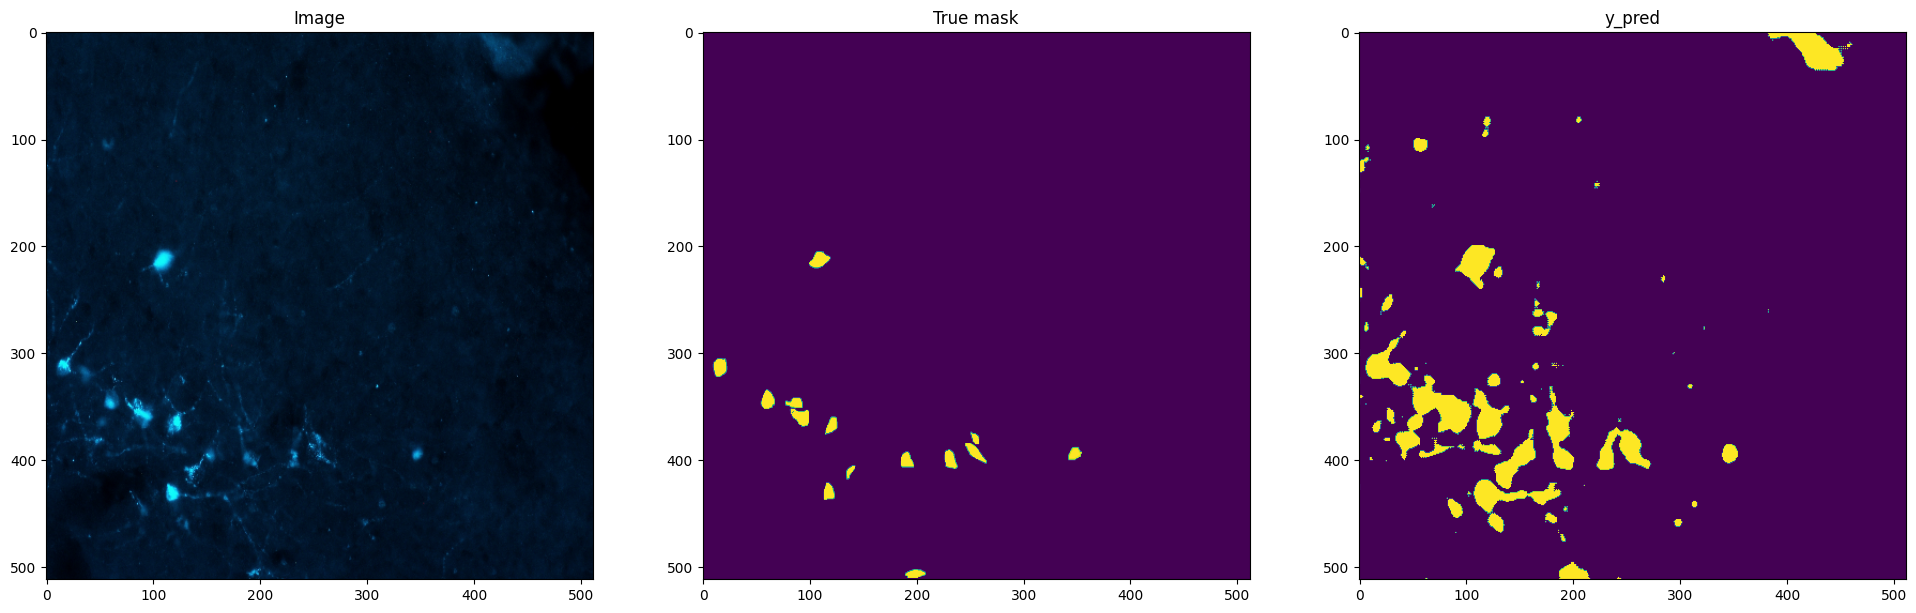

In [9]:
# testing the model
test = fc_dataset.__getitem__(10)
y_pred = model(test['image'])

print(torch.max(y_pred))

plt.figure(figsize=(24, 8))
plt.subplot(131)
plt.title("Image")
plt.imshow(test["image"].transpose(0,2))
plt.subplot(132)
plt.title("True mask")
plt.imshow(test['mask'].transpose(0, 2))
plt.subplot(133)
plt.title("y_pred")
plt.imshow(y_pred.detach().transpose(0, 2) > 0.5)

## References
1. [206 - The right way to segment large images by applying a trained U-Net model on smaller patches
](https://www.youtube.com/watch?v=LM9yisNYfyw)
    - Discouraged image resizing, recommended dividing images into patches for model training and image prediction. Only discusses images that are an aspect ratio divisible by network input (ie 768 x 1024 for a 256 x 256 model )
2. [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://link.springer.com/chapter/10.1007/978-3-319-24574-4_28)
    - Paper that implements U-Net architecture for mask production. Uses a paneling technique for images that are not perfectly divisible by the network input size that reflects a portion of the image across the border to complete the image (see figure 2). 